In [ ]:
#Importação das libs necessárias
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import string
from itertools import product
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import pickle
import itertools
import numpy as np
from sklearn.metrics import accuracy_score, precision_score,  recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from scipy.stats import norm, kstest, normaltest, ttest_ind
import seaborn as sns

In [ ]:
# Lê os dados de nomes pessoais e adiciona uma coluna de rótulo 'y' com valor 1
df_nomes = pd.read_csv('nomes_pessoais.csv')
df_nomes['y'] = 1

# Lê os dados de palavras comuns, faz uma amostra e adiciona uma coluna 'y' com valor 0
df_palavras = pd.read_csv('palavras_comuns.csv').sample(n=102561, random_state=42)
df_palavras['y'] = 0

# Concatena os dois DataFrames
df = pd.concat([df_nomes, df_palavras])
df.shape

(205122, 2)

In [ ]:
# Cria uma lista com todas as combinações de bigramas do alfabeto
alfabeto = list(string.ascii_uppercase)
alfabeto_bigrams = [''.join(bigram) for bigram in list(product(alfabeto, repeat=2))]

In [ ]:
# Configura o CountVectorizer para usar bigramas de caracteres
vectorizer = CountVectorizer(analyzer='char', vocabulary=alfabeto_bigrams, lowercase=False, ngram_range=(2, 2))

In [ ]:
Y = df['y']
Y.head()

0    1
1    1
2    1
3    1
4    1
Name: y, dtype: int64

In [ ]:
# Divide os dados em conjunto de treino e teste
X_train, X_test, y_train, y_test = train_test_split(df['X'], Y, test_size=0.3, random_state=42, stratify=Y)

In [ ]:
# Transforma os dados de treino e teste usando o CountVectorizer
X_train_vector = vectorizer.transform(X_train)
X_test_vector = vectorizer.transform(X_test)

In [ ]:
# Cria DataFrames para armazenar as contagens de classes no treino e no teste
treino = pd.DataFrame(y_train.value_counts()).rename({'count': 'Treinamento'}, axis=1).rename_axis(None, axis=0)
teste = pd.DataFrame(y_test.value_counts()).rename({'count': 'Teste'}, axis=1).rename_axis(None, axis=0)
df_dist = pd.concat([treino, teste], axis=1)
df_dist['Total'] = df_dist.sum(axis=1)
df_dist = pd.concat([df_dist, df_dist.sum().to_frame('Total').T])
df_dist.T

,1,0,Total
Treinamento,71793,71792,143585
Teste,30768,30769,61537
Total,102561,102561,205122


In [ ]:
# Dicionário para armazenar as predições dos modelos
y_predictions = {}

In [ ]:
# Treina um modelo SVM
from sklearn.svm import SVC

clf = SVC(gamma='auto', random_state=42)
clf.fit(X_train_vector, y_train)

SVC(gamma='auto', random_state=42)

In [ ]:
y_predictions['SVM'] = clf.predict(X_test_vector)


In [ ]:
accuracy_score(y_test, y_predictions['SVM'])


0.9298795846401352

In [ ]:
# Treina um modelo Random Forest
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_vector, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
y_predictions['Random Forest'] = rf.predict(X_test_vector)


In [ ]:
accuracy_score(y_test, y_predictions['Random Forest'])


0.963631636251361

In [ ]:
# Treina um modelo de Regressão Logística
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(random_state=42)
model.fit(X_train_vector, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=42)

In [ ]:
y_predictions['Logistic Regression'] = model.predict(X_test_vector)

In [ ]:
accuracy_score(y_test, y_predictions['Logistic Regression'])


0.9382485334026683

In [ ]:
# Treina um modelo de Gradient Boosting
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train_vector, y_train)

GradientBoostingClassifier(random_state=42)

In [ ]:
y_predictions['Gradient Boosting'] = gb.predict(X_test_vector)


In [ ]:
accuracy_score(y_test, y_predictions['Gradient Boosting'])


0.9021239254432293

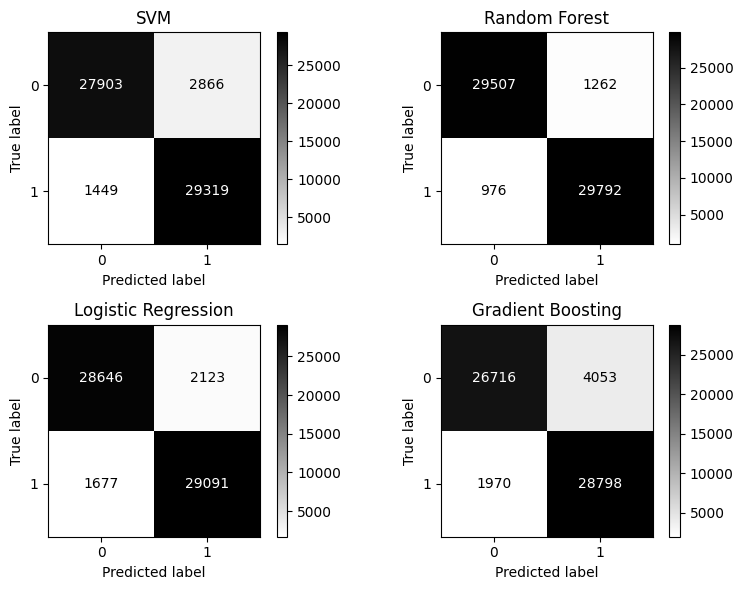

In [ ]:
# Plota as matrizes de confusão para cada modelo
fig, axs = plt.subplots(2, 2, figsize=(8, 6))

for model_name, y_pred, ax in zip(y_predictions.keys(), y_predictions.values(), axs.flat):
    cm = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred), display_labels=clf.classes_, )
    cm.plot(ax=ax, cmap='binary', values_format='d')
    ax.grid(False)
    ax.set_title(model_name)
plt.tight_layout()
# plt.savefig('imagens/matriz_confusao.png', bbox_inches='tight', dpi = 300)

In [ ]:
# Calcula e armazena as métricas de avaliação para cada modelo]
dfs = {}
for model_name, y_pred in y_predictions.items():
    report = {}
    report['accuracy'] = accuracy_score(y_test, y_pred)
    report['precision'] = precision_score(y_test, y_pred)
    report['recall'] = recall_score(y_test, y_pred)
    report['f1-score'] = f1_score(y_test, y_pred)
    dfs[model_name] = pd.DataFrame(report, index=[model_name])

In [ ]:
concatenated_df = pd.concat(dfs.values())
concatenated_df

,accuracy,precision,recall,f1-score
SVM,0.929880,0.910952,0.952906,0.931457
Random Forest,0.963632,0.959361,0.968279,0.963799
Logistic Regression,0.938249,0.931986,0.945495,0.938692
Gradient Boosting,0.902124,0.876625,0.935972,0.905327


In [ ]:
# Função para calcular scores de f1 usando validação cruzada
def f1_scores(model, X_train, y_train):
    scores = []
    for i in range(3):
        scores.extend(cross_val_score(estimator=model, X=X_train, y=y_train, cv=10, scoring='f1'))
    return scores

# Dicionários para armazenar os scores de f1 e outras métricas
scores_f1 = {}
scores_accuracy = {}
scores_std = {}
models = {'SVM': SVC(gamma='auto'), 'Random Forest': RandomForestClassifier(), 'Logistic Regression': LogisticRegression(), 'Gradient Boosting': GradientBoostingClassifier()}

In [ ]:
# Calcula scores de f1, acurácia média e desvio padrão para cada modelo
for name, model in models.items():
    scores_f1[name] = f1_scores(model, X_train_vector, y_train)
    scores_accuracy[name] = np.mean(scores_f1[name])
    scores_std[name] = np.std(scores_f1[name])

# Mostra os resultados
for name in models.keys():
    print(f'Modelo: {name}')
    print(f'  Acurácia Média: {scores_accuracy[name]:.4f}')
    print(f'  Desvio Padrão: {scores_std[name]:.4f}')

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Modelo: SVM
  Acurácia Média: 0.9293
  Desvio Padrão: 0.0022
Modelo: Random Forest
  Acurácia Média: 0.9620
  Desvio Padrão: 0.0019
Modelo: Logistic Regression
  Acurácia Média: 0.9379
  Desvio Padrão: 0.0023
Modelo: Gradient Boosting
  Acurácia Média: 0.9036
  Desvio Padrão: 0.0021


In [ ]:
# Salva os scores de f1 em um arquivo pickle
with open('scores_f1.pickle', 'wb') as arquivo:
  pickle.dump(scores_f1, arquivo)

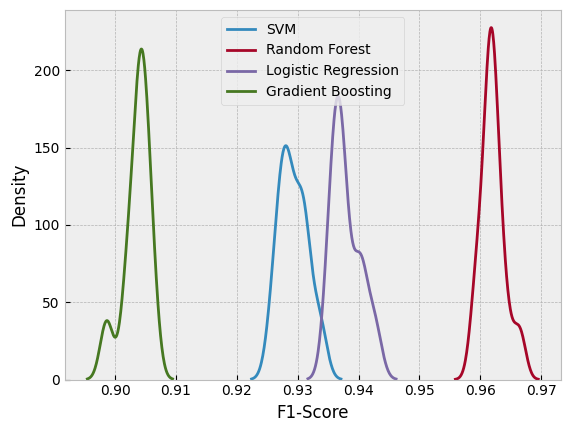

In [ ]:
# Plota a densidade dos scores de f1 para cada modelo
for name, scores in scores_f1.items():
    sns.kdeplot(scores, label=name)
plt.xlabel('F1-Score', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend(fontsize=10)
plt.tick_params(labelsize=10)
# plt.savefig('kde.png', bbox_inches='tight', dpi = 300)
plt.show()

In [ ]:
# Teste de normalidade nos scores de f1 para cada modelo
results = {}
for model, score in scores_f1.items():
    t_stat, p_value = normaltest(score)
    results[model] = p_value

In [ ]:
# Formata os resultados dos testes de normalidade
for name_model, result in results.items():
    results[name_model] = format(result, '.17f')

In [ ]:
results_df = pd.DataFrame({
    'Modelo': results.keys(),
    'p-value': results.values()
})

In [ ]:
results_df

,Modelo,p-value
0,SVM,0.44793698515362035
1,Random Forest,0.12485261484345800
2,Logistic Regression,0.16363696281278287
3,Gradient Boosting,0.01137477266319048


In [ ]:
# Adiciona a conclusão dos testes de normalidade
results_df['H0'] = ['reject' if valor < '0.05' else 'accept' for valor in results_df['p-value']]

In [ ]:
results_df

,Modelo,p-value,H0
0,SVM,0.44793698515362035,accept
1,Random Forest,0.12485261484345800,accept
2,Logistic Regression,0.16363696281278287,accept
3,Gradient Boosting,0.01137477266319048,reject


In [ ]:
# Função para realizar o teste de Kolmogorov-Smirnov
def ks(y_pred_1, y_pred_2):
    density_1 = norm.pdf(y_pred_1, np.mean(y_pred_1), np.std(y_pred_1))
    density_2 = norm.pdf(y_pred_2, np.mean(y_pred_2), np.std(y_pred_2))
    return kstest(density_1, density_2)

In [ ]:
# Combinações de modelos para comparação
combinacoes_models = list(itertools.combinations(list(scores_f1.keys()), 2))

In [ ]:
# Testa diferenças significativas entre modelos
testes = {'Modelo 1': [], 'Modelo 2': [], 'p-value': [], 'Teste': []}
for model_1, model_2 in combinacoes_models:
    if model_1 == 'Gradient Boosting' or model_2 == 'Gradient Boosting':
        testes['Teste'].append('Kolmogorov-Smirnov')
        t_stat, p_value = ks(scores_f1[model_1], scores_f1[model_2])
    else:
        testes['Teste'].append('t-Student')
        t_stat, p_value = ttest_ind(scores_f1[model_1], scores_f1[model_2])
    testes['Modelo 1'].append(model_1)
    testes['Modelo 2'].append(model_2)
    testes['p-value'].append(format(p_value, '.17f'))

In [ ]:
final_results = pd.DataFrame(testes)

In [ ]:
# Adiciona a conclusão dos testes de comparação
final_results['H0'] = ['reject' if valor < '0.05' else 'accept' for valor in final_results['p-value']]

In [ ]:
final_results

,Modelo 1,Modelo 2,p-value,Teste,H0
0,SVM,Random Forest,0.00000000000000000,t-Student,reject
1,SVM,Logistic Regression,0.00000000000000000,t-Student,reject
2,SVM,Gradient Boosting,0.01564339049675433,Kolmogorov-Smirnov,reject
3,Random Forest,Logistic Regression,0.00000000000000000,t-Student,reject
4,Random Forest,Gradient Boosting,0.00029334054913621,Kolmogorov-Smirnov,reject
5,Logistic Regression,Gradient Boosting,0.00089957768401768,Kolmogorov-Smirnov,reject
